In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from lenstronomy.LightModel.Profiles.interpolation import Interpol
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.ImSim.image_model import ImageModel
# from lenstronomy.SimulationAPI.simapi import magntiude2amplitude
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.Util.param_util import phi_q2_ellipticity
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util.analysis_util import half_light_radius
from lenstronomy.Analysis.td_cosmography import TDCosmography
from lenstronomy.PointSource.point_source import PointSource
import lenstronomy.Util.data_util as data_util
from astropy.io import fits
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
import scipy.optimize as opt
import sncosmo
from scipy.stats import norm, uniform, truncnorm
import glob, tqdm
import pandas as pd
from matplotlib_scalebar.scalebar import ScaleBar
import dustmaps.planck
from dustmaps.config import config
from dustmaps.planck import PlanckGNILCQuery
from astropy.coordinates import SkyCoord

/global/homes/v/vikramb/.conda/envs/lens_sim/lib/python3.11/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


In [3]:
# size of eistein radius - 0.02-0.15, 0.15-0.5, 0.5-1.5 arcsec

size=".5-1.5"
# size=".15-.5"
# size=".02-.15"

In [4]:
# import library which has cosmodc2 - synthetic halo catalog for lenses
import GCRCatalogs
cat = GCRCatalogs.load_catalog("desc_cosmodc2")
keys = ['redshift', 'halo_mass', 'stellar_mass', 'size_true', 'ellipticity_1_true', 'ellipticity_2_true', 'is_central']
dc2 = cat.get_quantities(keys)

# unsure what is_central does, only take certain halo mass depending on einstein radius?
if size=='.5-1.5':
    inds = dc2['is_central']*(dc2['halo_mass']>1e13)
elif size=='.15-.5':
    inds = dc2['is_central']*(dc2['halo_mass']>5e12)*(dc2['halo_mass']<5e13)
elif size=='.02-.15':
    inds = dc2['is_central']*(dc2['halo_mass']>1e10)*(dc2['halo_mass']<5e12)

# make dc2 store only certain masses as depedant on above
ms = cat.get_quantities('stellar_mass')['stellar_mass']
for key in keys:
    dc2[key] = dc2[key][inds]
# randomly shuffle redshift inds?
zinds = np.arange(len(dc2['redshift']))
np.random.shuffle(zinds)

# store redshifts as stellar mass of halos
zs_dc2 = dc2['redshift']
ms_dc2 = dc2['stellar_mass']

# unsure what this does, zahid converts halo_mass to velocity dispersion
ms_dict = np.load('/global/cfs/projectdirs/deepsrch/jwst_sims/datasets/zahid_ms.npz')
if size==".15-.5":
    size=".05-.5"
sizes = np.array(ms_dict.files)
low, up = np.array([float(_) for _ in size.split('-')])
sizes_f = [float(_) for _ in sizes]
sizes = sizes[(sizes_f>=low)*(sizes_f<up)]
if size==".05-.5":
    size=".15-.5"

In [5]:
def mHalo(m, z):
    if z<.5:
        M1 = 10**12.629
        M0 = 10**10.855
        beta=0.487
        delta=0.935
        gamma=1.939
    elif z<.8:
        M1 = 10**12.793
        M0 = 10**10.927
        beta=0.502
        delta=0.802
        gamma=3.132    
    elif z < 1.1:
        M1 = 10**12.730
        M0 = 10**11.013
        beta=0.454
        delta=1.109
        gamma=1.925    
    elif z < 1.5:
        M1 = 10**12.673
        M0 = 10**10.967
        beta=0.393
        delta=0.746
        gamma=0.335    
    elif z < 2.0:
        M1 = 10**12.787
        M0 = 10**11.040
        beta=0.410
        delta=0.716
        gamma=1.312   
    elif z < 2.5:
        M1 = 10**13.097
        M0 = 10**11.254
        beta=0.495
        delta=0.668
        gamma=1.077    
    elif z < 3.0:
        M1 = 10**12.627
        M0 = 10**10.920
        beta=0.393
        delta=0.274
        gamma=0.447   
    elif z < 3.5:
        M1 = 10**12.820
        M0 = 10**11.067
        beta=0.465
        delta=0.354
        gamma=0.741    
    elif z < 4.5:
        M1 = 10**13.638
        M0 = 10**12.222
        beta=0.551
        delta=1.557
        gamma=3.149    
    else:
        M1 = 10**13.547
        M0 = 10**12.105
        beta=0.567
        delta=1.427
        gamma=3.225    
                        
    Mhalo = 10**(np.log10(M1)+beta*np.log10(m/M0)+((m/M0)**delta)/(1+(m/M0)**(-gamma))-1/2)
    return Mhalo

def stellar_mass(M, z):
    mM10 = 11.88
    mu = 0.019
    mM00 = 0.0282
    nu = -0.72
    gamma0 = 0.556
    gamma1 = -0.26
    beta0 = 1.06
    beta1 = 0.17
    
    M1=10**(11.88*(z+1)**mu)
    mM0=mM00*(z+1)**nu
    gamma = gamma0*(z+1)**gamma1
    beta = beta1*z+beta0
    shmr = 2*mM0/((M/M1)**(-beta)+(M/M1)**gamma)
    return shmr * M

# load halo redshifts?
# zs = np.load("/global/cfs/projectdirs/deepsrch/jwst_sims/datasets/halo_zs2.npy")
# load vela catalog (detailed source images)
vela_cat = pd.read_csv("/global/cfs/projectdirs/deepsrch/jwst_sims/datasets/JWST/hlsp_vela_multi_multi_vela_multi_v3_cat.txt", delim_whitespace=True)
vela_cat

,sim,z,scale,cam,mission,instrument,filter,flux_njy,abmag,mstar,mgas,mmet,sfr,mvir_dm,path
0,vela01,19.000000,0.05,cam00,hst,acs,f435w,0.000000e+00,NaN,2.713491e+05,8.672512e+10,5.582583e+02,0.317644,2.430748e+08,vela/vela01/cam00/hst/acs/f435w/hlsp_vela_hst_...
1,vela01,15.666667,0.06,cam00,hst,acs,f435w,1.916872e-32,110.693583,1.292812e+06,6.287650e+10,1.109931e+04,0.249550,5.074384e+08,vela/vela01/cam00/hst/acs/f435w/hlsp_vela_hst_...
2,vela01,13.285714,0.07,cam00,hst,acs,f435w,8.964136e-27,96.518795,2.304172e+06,5.971775e+10,2.083764e+04,0.975671,1.172963e+09,vela/vela01/cam00/hst/acs/f435w/hlsp_vela_hst_...
3,vela01,11.500000,0.08,cam00,hst,acs,f435w,3.324756e-23,87.595666,6.421828e+06,4.147531e+10,6.125115e+04,1.051829,2.250957e+09,vela/vela01/cam00/hst/acs/f435w/hlsp_vela_hst_...
4,vela01,10.111111,0.09,cam00,hst,acs,f435w,1.504973e-19,78.456244,1.317297e+07,3.853616e+10,1.457750e+05,2.183615,3.149162e+09,vela/vela01/cam00/hst/acs/f435w/hlsp_vela_hst_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807018,vela35,8.090909,0.11,cam18,wfirst,wfidrm15,z087,2.062675e-02,35.613989,2.376371e+08,4.918993e+10,2.291054e+06,14.120490,3.063316e+10,vela/vela35/cam18/wfirst/wfidrm15/z087/hlsp_ve...
807019,vela35,7.333333,0.12,cam18,wfirst,wfidrm15,z087,2.558612e-01,32.880055,3.429454e+08,3.890345e+10,2.956734e+06,30.825400,4.156953e+10,vela/vela35/cam18/wfirst/wfidrm15/z087/hlsp_ve...
807020,vela35,6.692308,0.13,cam18,wfirst,wfidrm15,z087,5.853500e+00,29.481526,6.192816e+08,3.175911e+10,4.611881e+06,27.574380,5.302207e+10,vela/vela35/cam18/wfirst/wfidrm15/z087/hlsp_ve...
807021,vela35,6.142857,0.14,cam18,wfirst,wfidrm15,z087,2.230114e+01,28.029248,9.749514e+08,3.329994e+10,6.080173e+06,50.632260,6.498438e+10,vela/vela35/cam18/wfirst/wfidrm15/z087/hlsp_ve...


In [6]:
# load williams catalog image
with fits.open('/global/cfs/projectdirs/deepsrch/jwst_sims/datasets/JWST/goods_s_F115W_2018_08_29.fits') as hdul:
    header = hdul[0].header
    sim = hdul[0].data * header['GAIN']
wcs = WCS(header)

# list of all objects 
with fits.open('/global/cfs/projectdirs/deepsrch/jwst_sims/datasets/JWST/JADES_SF_mock_r1_v1.1.fits') as hdul:
    data_sf = hdul[1].data
with fits.open('/global/cfs/projectdirs/deepsrch/jwst_sims/datasets/JWST/JADES_Q_mock_r1_v1.1.fits') as hdul:
    data_q = hdul[1].data
    
dec = [-27.83, -27.785]
ra = [53.137, 53.222]

# what are these cuts for?
cut_sf= data_sf[data_sf['RA']>53.137]
cut_sf = cut_sf[cut_sf['RA']<53.222]
cut_sf = cut_sf[cut_sf['DEC']>-27.83]
cut_sf = cut_sf[cut_sf['DEC']<-27.785]
cut_q= data_q[data_q['RA']>53.137]
cut_q = cut_q[cut_q['RA']<53.222]
cut_q = cut_q[cut_q['DEC']>-27.83]
cut_q = cut_q[cut_q['DEC']<-27.785]

sum_to_flux = 4.377063704561799
def ML_ratio(z):
    return 10**(2.15259223299506*np.log10(z)+6.61731435158865)

In [7]:
# list of redshifts
velas = glob.glob('/global/cfs/projectdirs/deepsrch/vela_roman/vela01/cam00/wfirst/wfidrm15/y106/*')
velas.sort()
redshifts = np.zeros(len(velas))
for i in range(len(velas)):
    with fits.open(velas[i]) as hdul:
        vela_h = hdul[1].header
        vela_d = hdul[1].data
#         print(vela_h['REDSHIFT'])
        redshifts[i] = vela_h['REDSHIFT']
# cams where direction is random
cams = np.array(["cam12", "cam13", "cam14", "cam15", "cam16", "cam17", "cam18"])
sims = glob.glob('/global/cfs/projectdirs/deepsrch/vela/*')
sims = np.array([sim[-6:] for sim in sims])
# redshifts for vela catalog
redshifts

array([19.   , 15.667, 13.286, 11.5  , 10.111,  8.091,  7.333,  6.692,
        6.143,  5.667,  5.25 ,  4.882,  4.263,  4.   ,  3.762,  3.545,
        3.348,  3.167,  3.   ,  2.846,  2.704,  2.571,  2.448,  2.333,
        2.226,  2.125,  2.03 ,  1.941,  1.857,  1.778,  1.703,  1.632,
        1.564,  1.5  ,  1.439,  1.381,  1.326,  1.273,  1.222,  1.174,
        1.128,  1.083,  1.041,  1.   ])

In [8]:
vela_h

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  800                                                  
NAXIS2  =                  800                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
REDSHIFT=                  1.0                                                  
PIXSIZE = 0.007718915158538387 / arcsec                                         
PIXKPC  =               0.0625 / kpc                                            
IMUNIT  = 'nanoJanskies'                                                        
SBFACTOR=   0.5277637712944407 / Image=SBFACTOR*Original                        
EFLAMBDA=    1.0632840037195

In [9]:
source_z = truncnorm.rvs(-1/3,2/3, loc=1.5, scale=3)
# random sim and cam from vela - finds nearest redshift index
sim = np.random.choice(sims)
cam = np.random.choice(cams)

redshifts = glob.glob('/global/cfs/projectdirs/deepsrch/vela_roman/'+sim+'/'+cam+'/wfirst/wfidrm15/y106/*')
redshifts = np.array([1/(int(r[120:123])/1000)-1 for r in redshifts])
redshifts = np.sort(redshifts)[::-1]
i = np.argmin(np.abs(redshifts-source_z))

velas = glob.glob('/global/cfs/projectdirs/deepsrch/vela_roman/'+sim+'/'+cam+'/wfirst/wfidrm15/y106/*')
velas.sort()
# actual image
vela_d = fits.open(velas[i])[1].data
query = vela_cat.query("sim=='"+sim+"' and cam=='"+cam+"' and z==%.8f and filter=='y106'" % np.round(redshifts[i],8))

In [10]:
np.sum(vela_d)

3622.876

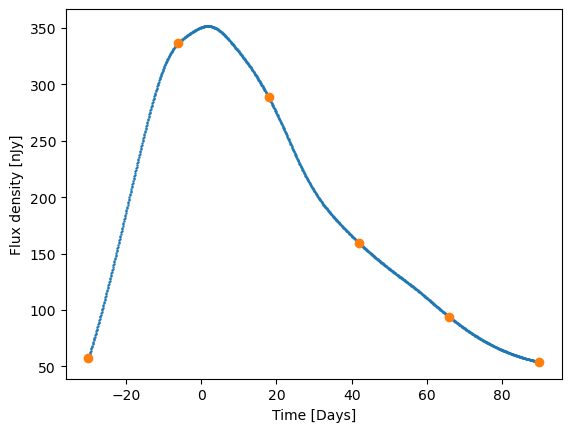

In [17]:
SOURCE_REDSHIFT = 1
LENS_REDSHIFT = 0.5

# flux in ergs/s/cm**2/angstrom
def mag_from_sfd(sfd, lam):
    watt = 1e-7
    m = 0.01
    m_lam = 1e-10
    c = 299792458
    jy = 1e23
    nano = 1e9
    freq = c / (lam * m_lam)
    njy = sfd * lam / freq * jy * nano
    return njy

def njy_from_mag(mag):
    return 1000*10**(0.4*(23.9-mag))


def sn_mag(lam, z):
    c = SkyCoord(53, -27, frame='icrs', unit='deg')
    mwdust = PlanckGNILCQuery()(c)
    dust = sncosmo.CCM89Dust()
    c = np.random.normal(0,0.1)
    x1 = np.random.normal(0, 1)
    hostebv = np.abs(np.random.normal(0.2, 0.1))
    hostr_v = np.abs(np.random.normal(3, 0.5))
    ia_abs_mag = np.random.normal(-19.26, 0.51)
    
    mod = sncosmo.Model(source='salt3', effects=[dust, dust], effect_names=['mw', 'host'], effect_frames=['obs', 'rest'])
    mod.update({"c":c, "x1":x1, "z":z, "mwebv":mwdust, "mwr_v":3.1, 
            "hostebv":hostebv, "hostr_v":hostr_v})
    mod.update({"t0": 0})
    mod.set_source_peakabsmag(ia_abs_mag, 'bessellb', 'ab')
    # lam_z = lam*z+lam
    times = np.arange(-15*(1+z), 45*(1+z), 0.1)
    # flux = mod.flux(times, [lam])[:,0]
    bandmag = mod.bandmag('f106', 'ab', times)
    # print(f'c: {c}, x1: {x1}, source_z: {SOURCE_REDSHIFT}, t0: {0}')
#     inds = [flux > 0][0]
#     # print(inds.shape, flux.shape)
#     times = times[inds]
#     flux = flux[inds]
    
    return times, bandmag

f106 = 10600.0
# lambda_z_f106 = f106 * SOURCE_REDSHIFT + f106
times, mag = sn_mag(f106, SOURCE_REDSHIFT)
njy = njy_from_mag(mag)
inds = list(map(int,np.linspace(0, len(njy)//6*6-1, 6)))
plt.scatter(times, njy, s=0.5)
plt.scatter(times[inds], njy[inds])
plt.xlabel('Time [Days]')
plt.ylabel('Flux density [nJy]')
plt.show()

In [12]:
def time_delay(z_lens, z_source, kwargs_model, cosmo, kwargs_lens, kwargs_ps):
    # time delays, the unit [days] is matched when the lensing angles are in arcsec
    td_cosmo = TDCosmography(z_lens, z_source, kwargs_model, cosmo_fiducial=cosmo)

    # time delays, the unit [days] is matched when the lensing angles are in arcsec
    t_days = td_cosmo.time_delays(kwargs_lens, kwargs_ps, kappa_ext=0)
    print("the time delays for the images at position ", kwargs_ps[0]['ra_image'], kwargs_ps[0]['dec_image'], "are: ", t_days)

    # relative delays (observable). The convention is relative to the first image
    dt_days =  t_days[1:] - t_days[0]
    # and errors can be assigned to the measured relative delays (full covariance matrix not yet implemented)
    dt_sigma = [3, 5, 2]  # Gaussian errors
    # and here a realisation of the measurement with the quoted error bars
    dt_measured = np.random.normal(dt_days, dt_sigma)
    return dt_measured

In [13]:
# setting up lenstronomy stuff
sum_to_flux = 6.501853565914121
# 125
pixels = vela_d.shape[0]
# 0.03
pixel_size = vela_h['PIXSIZE']
# background_rms = header['BKG']
background_rms = 0.384
exp_time = 300

# kwargs
kwargs_data = {'background_rms': background_rms, 'exposure_time': exp_time,
               'ra_at_xy_0': -pixels/2*pixel_size, 'dec_at_xy_0': -pixels/2*pixel_size,
               'transform_pix2angle':np.array([[pixel_size, 0.  ], [0.  , pixel_size]]), 
               'image_data': np.zeros((pixels, pixels))}
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
data_class = ImageData(**kwargs_data)

# PSF
psf_filename = r"F106.fits"
kernel = fits.open(psf_filename)[0].data
# self.obs.update({"psf_type": "PIXEL", "kernel_point_source": kernel})
# kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.03, 'pixel_size': pixel_size, 'truncation': 3}
kwargs_psf = {'psf_type': 'PIXEL', "kernel_point_source": kernel}
psf_class = PSF(**kwargs_psf)

# lens params
lens_light_model_class = LightModel(['SERSIC_ELLIPSE'])
lens_model_class = LensModel(['EPL'], z_lens=LENS_REDSHIFT, z_source=SOURCE_REDSHIFT)
n_sersic = uniform.rvs(loc=2, scale=4)
e1, e2 = truncnorm.rvs(-3, 3, loc=0, scale=0.05, size = 2)
gamma = truncnorm.rvs(1.2, 2.8, loc=2, scale=0.25)
center_x, center_y = norm.rvs(loc=0, scale=0.1, size=2)
kwargs_lens = [{'theta_E':1, 'gamma': gamma, e1':e1, 'e2':e2, 'center_x': center_x, 'center_y': center_y}]
kwargs_lens_light = [{'amp':1, 'R_sersic': 1, 'n_sersic': n_sersic, 'e1':e1, 'e2':e2, 'center_x': center_x, 'center_y': center_y}]

# source params
source_model_class = LightModel(['INTERPOL'])
source_x, source_y = 0.0, 0.0
kwargs_source = [{'image':vela_d, 'amp':1, 'scale':pixel_size, 'center_x': source_x, 'center_y': source_y}]

# generate supernova center
pixs = np.arange(vela_d.shape[0])
hl_rad = half_light_radius(vela_d, x_grid=pixs, y_grid=pixs, center_x=np.mean(pixs), center_y=np.mean(pixs))
center = np.random.uniform(hl_rad*0.5, hl_rad*5)
angle = np.random.uniform(0, 2*np.pi)
sn_x, sn_y = hl_rad*np.cos(angle)*pixel_size, hl_rad*np.sin(angle)*pixel_size

# supernova part
lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(sn_x, sn_y, kwargs_lens, numImages=4,
                                                      min_distance=pixel_size, search_window=pixels * pixel_size)
mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
                           'point_amp': 1}]  # quasar point source position in the source plane and intrinsic brightness
point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])

image_model = ImageModel(data_class=data_class, psf_class=psf_class, lens_model_class=lens_model_class, 
    source_model_class=source_model_class, lens_light_model_class=lens_light_model_class, point_source_class=point_source_class,
    kwargs_numerics=kwargs_numerics)

kwargs_lens[0]['theta_E'] = 0
just_source = image_model.image(kwargs_lens, kwargs_source, kwargs_lens_light=kwargs_lens_light, kwargs_ps=kwargs_ps,
                               source_add=True, lens_light_add=False)
kwargs_lens[0]['theta_E'] = 1
just_sn = image_model.image(kwargs_lens, kwargs_source, kwargs_lens_light=kwargs_lens_light, kwargs_ps=kwargs_ps,
                               source_add=False, lens_light_add=False)
just_lens = image_model.image(kwargs_lens, kwargs_source, kwargs_lens_light=kwargs_lens_light, kwargs_ps=kwargs_ps,
                               source_add=False, lens_light_add=True)

# source amp parameter
calc_sum = sum_to_flux * query['flux_njy'].values[0]
# scale up for theta_e 0.5-1.5 
scale_up = 10**(uniform.rvs(loc=.5,scale=1.5))
kwargs_source[0]['amp'] = calc_sum/np.sum(just_source) * scale_up

# # lens amp parameter
mStar = 199583464713.6332
lStar =  mStar / ML_ratio(LENS_REDSHIFT)
calc_sum = sum_to_flux * lStar
kwargs_lens_light[0]['amp'] = calc_sum/np.sum(just_lens)

# set up time delay cosmology
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)
kwargs_model = {'lens_model_list': ['EPL'], 
                 'lens_light_model_list': ['SERSIC_ELLIPSE'],
                 'source_light_model_list': ['INTERPOL'],
                'point_source_model_list': point_source_list}


# sample supernova flux
f106 = 10600.0
mg = sn_mag(f106, SOURCE_REDSHIFT)[1]
inds = np.linspace(0, len(mg)//6*6-1, 6)
time_delays = time_delay(LENS_REDSHIFT, SOURCE_REDSHIFT, kwargs_model, cosmo, kwargs_lens, kwargs_ps)

fig, ax = plt.subplots(2, 3, figsize=(10,7))
ax = ax.ravel()
for i,v in enumerate(inds):
    t_mag = mg[int(v)]
    snv_mag = sum_to_flux * njy_from_mag(t_mag)
    kwargs_ps[0]['point_amp'] = snv_mag/np.sum(just_source)*np.abs(mag)
    # print(kwargs_ps[0]['point_amp'], kwargs_source[0]['amp'], kwargs_lens_light[0]['amp'])
    
    im = image_model.image(kwargs_lens, kwargs_source, kwargs_lens_light=kwargs_lens_light, kwargs_ps=kwargs_ps,
                                   source_add=True, lens_light_add=True)

    poisson = image_util.add_poisson(im/1.547190779092E+02, exp_time=exp_time)*1.547190779092E+02
    bkg = image_util.add_background(im, sigma_bkd=background_rms)
    im = im + poisson + bkg

    ax[i].imshow(im, vmin=0, vmax = np.percentile(im,99))
    scalebar = ScaleBar(pixel_size,units="''",dimension='angle',fixed_value=1,box_alpha=1e-07,color='white',
                        location='lower left',scale_loc='top',font_properties={'size':'large'})
    ax[i].add_artist(scalebar)
fig.tight_layout()
plt.show()

SyntaxError: unterminated string literal (detected at line 34) (3140341882.py, line 34)